# Radial Velocities

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
from maelstrom.kepler import kepler

/home/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Read in the light curve, the frequencies, and then the RV data.

In [3]:
kicid = 8311110

times, dmag = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T

# Subtract midpoint
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid

# mmags
dmmags = dmag * 1000. 

nu_arr = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)[::6]

It might be cleaner just to use n-d numpy arrays (or better yet, inherit from Maelstrom class) - but with an object i won't need to use matrix indexing 

In [4]:
class RadialVelocity(object):
    def __init__(self, time, velocity, err=None, meta={}):
        self.time = time
        self.vel = velocity
        if err is not None:    # this if looks unintuitive but python doesn't like 'if not err'
            self.err = err
        self.meta = meta

        T=tf.float64
        self.time_tensor = tf.placeholder(T)
        self.rv_tensor = tf.placeholder(T)
        self.err_tensor = tf.placeholder(T)

In [5]:
rvs = []
# Make sure glob is sorted to read in alphabetically
# Glob also has to be * and not ?, otherwise it won't pick up kicid_JDrv data (i.e. single RV)
for file in sorted(glob.glob(f"data/kic{kicid}*_JDrv.txt")):
    rv = RadialVelocity(*np.loadtxt(file, delimiter=",", usecols=(0,1,2)).T, file[15:-9])
    rv.time -= time_mid
    rvs.append(rv)

In [6]:
rvs[1].meta

'b'

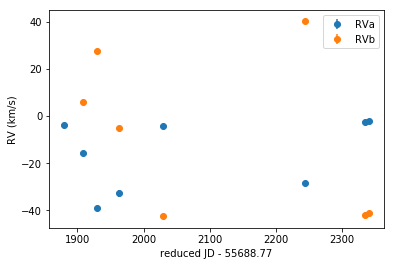

In [7]:
# plot just the RVs for now
for rv in rvs:
    plt.errorbar(rv.time, rv.vel, rv.err, fmt="o", label='RV'+rv.meta)
plt.xlabel(f"reduced JD - {np.round(time_mid,2)}")
plt.ylabel("RV (km/s)")
plt.legend()
plt.show()

In [8]:
# read in the table of orbits
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())

orb_params = orbits[orbits.Name == f"kic{kicid}"].iloc[0]

# this is basically cheating
porb = orb_params.Porb
a1 = orb_params["a1sini/c"]
tp = orb_params["t_p"] - time_mid
e = orb_params["e"]
e_param = np.log(e) - np.log(1.0 - e)

for rv in rvs:
    rv.varpi = orb_params["varpi"]
    rv.ad = a1/86400.0

In [9]:
sess = tf.InteractiveSession()

In [10]:
T = tf.float64

# First the variables that we might want to optimize:
porb_tensor = tf.Variable(porb, dtype=T)
tp_tensor = tf.Variable(tp, dtype=T)
nu_tensor = tf.Variable(nu_arr, dtype=T)
e_param_tensor = tf.Variable(e_param, dtype=T)  # This forces the ecc to be between 0 and 1
e_tensor = 1.0 / (1.0 + tf.exp(-e_param_tensor))
log_sigma2_tensor = tf.Variable(0.0, dtype=T)  # Variance from observational uncertainties and model misspecification
gammav_tensor = tf.Variable(np.mean(rvs[0].vel) / 299792.458, dtype=T)

for rv in rvs:
    rv.varpi_tensor = tf.Variable(rv.varpi, dtype=T)
    rv.ad_tensor = tf.Variable(rv.ad, dtype=T)
    rv.log_rv_sigma2_tensor = tf.Variable(np.log(np.median(rv.err)), dtype=T)  # RV jitter

# These are some placeholders for the data:
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)

# Solve Kepler's equation
mean_anom = 2.0 * np.pi * (times_tensor - tp_tensor) / porb_tensor
ecc_anom = kepler(mean_anom, e_tensor)
true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*ecc_anom),tf.sqrt(1.0-e_tensor) + tf.zeros_like(times_tensor))

Calculate the model and likelihood for the time delays

In [11]:
# Here we define how the time delay will be calculated:
# For now, assume only kic_a star is pulsating:
tau_tensor = -rvs[0].ad * (1.0 - tf.square(e_tensor)) * tf.sin(true_anom + rvs[0].varpi) / (1.0 + e_tensor*tf.cos(true_anom))

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor - tau_tensor)[:, None]
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2_tensor += len(times) * log_sigma2_tensor

# Dict holds both the tf variables and their respective bounds
var_dict = {
    porb_tensor: (0, None),
    tp_tensor: (None, None),
    e_param_tensor: (None, None),
    log_sigma2_tensor: (None, None),
    gammav_tensor: (None, None)
}

for rv in rvs:
    # Solve Kepler's equation for the RVs
    rv.mean_anom = (2.0 * np.pi * (rv.time_tensor - tp_tensor) / porb_tensor)
    rv.ecc_anom = kepler(rv.mean_anom, e_tensor)
    rv.true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*rv.ecc_anom), tf.sqrt(1.0-e_tensor) + tf.zeros_like(rv.time_tensor))

    # Here we define how the RV will be calculated:
    rv.vrad_tensor = -2.0 * np.pi * (rv.ad_tensor / porb_tensor) * (1/tf.sqrt(1.0 - tf.square(e_tensor))) * (tf.cos(rv.true_anom + rvs[0].varpi_tensor) + e_tensor*tf.cos(rvs[0].varpi_tensor))
    rv.vrad_tensor += gammav_tensor
    rv.vrad_tensor *= 299792.458  # c in km/s

    rv.sig2 = tf.square(rv.err_tensor) + tf.exp(rv.log_rv_sigma2_tensor)
    rv.chi = tf.square(rv.rv_tensor - rv.vrad_tensor) / rv.sig2 + tf.log(rv.sig2)
    chi2_tensor += tf.reduce_sum(rv.chi)
    
    var_dict.update({
        rv.log_rv_sigma2_tensor: (None, None)
    })

var_dict.update({
    rvs[0].ad_tensor: (0, None),
    rvs[1].ad_tensor: (None, 0),
    rvs[0].varpi_tensor: (None, None)
})

init = tf.global_variables_initializer()
sess.run(init)

In [12]:
feed_dict = {
    times_tensor: times,
    dmmags_tensor: dmmags
}

for rv in rvs:
    feed_dict.update({
        rv.time_tensor: rv.time,
        rv.rv_tensor: rv.vel,
        rv.err_tensor: rv.err,
    })

In [13]:
sess.run(chi2_tensor, feed_dict=feed_dict)

157517.42309475248

In [14]:
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, var_list=list(var_dict.keys()),var_to_bounds=var_dict)
for i in range(3):
    opt.minimize(sess, feed_dict=feed_dict)

Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97768.491361
  Number of iterations: 12
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97768.491268
  Number of iterations: 1
  Number of functions evaluations: 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 97768.491175
  Number of iterations: 1
  Number of functions evaluations: 3


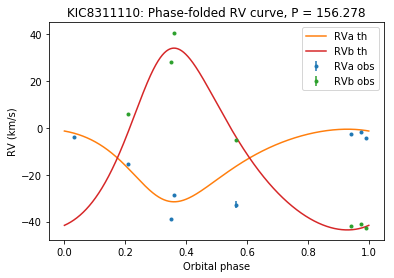

In [15]:
for rv in rvs:
    rv_phi_test = np.sort(np.linspace(0, sess.run(porb_tensor), 5000) % sess.run(porb_tensor))
    vrad = sess.run(rv.vrad_tensor, feed_dict={rv.time_tensor: rv_phi_test})

    plt.errorbar((rv.time % sess.run(porb_tensor))/sess.run(porb_tensor),rv.vel,rv.err,fmt=".",label='RV'+rv.meta+' obs')
    plt.plot(rv_phi_test/sess.run(porb_tensor), vrad,label='RV' +rv.meta+' th')

plt.xlabel("Orbital phase")
plt.ylabel("RV (km/s)")
plt.title("KIC"+str(kicid) + ": Phase-folded RV curve, P = " + f"{np.round(sess.run(porb_tensor),3)}")
plt.legend()
plt.show()

In [16]:
print(f"e: {np.round(sess.run(e_tensor),3)}")
print(f"porb: {np.round(sess.run(porb_tensor),3)}")
print(f"tp: {np.round(sess.run(tp_tensor)+time_mid,3)}")
print(f"varpi = {np.round(sess.run(rvs[0].varpi_tensor),3)} s")
for rv in rvs:
    print("asini/c_"+rv.meta+ ": " + str(np.round(sess.run(rv.ad_tensor)*86400.,3)))

e: 0.234
porb: 156.278
tp: 55112.711
varpi = 5.81 s
asini/c_a: 107.803
asini/c_b: -269.964


In [17]:
print(orb_params)

Name                   kic8311110
Porb                      156.307
Porb_sig_p               0.126687
Porb_sig_m               0.128791
a1sini/c                  174.009
a1sini/c_sig_p             2.7666
a1sini/c_sig_m            2.70491
e                        0.234021
e_sig_p                   0.02975
e_sig_m                   0.03037
phip                     0.987294
phip_sig_p               0.016272
phip_sig_m               0.020086
varpi                     5.76828
varpi_sig_p              0.098538
varpi_sig_m              0.121139
f(M)Msun                 0.231551
f(M)Msun_sig_p           0.011051
f(M)Msun_sig_m          0.0108047
gradient                -0.009634
grad_sig_p               0.004132
grad_sig_m               0.004138
t_p                       55112.7
t_p_sig_p                 2.54663
t_p_sig_m                 3.14217
K1_ms                     23598.8
K1_ms_sig_p                 324.4
K1_ms_sig_m                 314.2
median_segment_size           NaN
Name: 238, dty